# Identifying dogs versus cats using RNN Models

The goal is to identify if a picture contains a cat or dog of various kinds and with different backgrounds. This type of identification can be extrapolated to identifying a car in an image or a pedestrian. 

In [39]:
import os, cv2, glob

import random
import numpy as np
import pandas as pd

import sklearn.model_selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay, auc, PrecisionRecallDisplay

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

## Data ingest

In [3]:
os.chdir('/mnt/c/Users/jwnha/Documents/_School/MSDS/2022 Winter/Machine Learning/Week 8/cnn-identify-dogs-v-cats/data/train/')

In [4]:
trainLabel = []
trainImagePaths = []

for infile in glob.glob("*.jpg"):
    trainImagePaths.append(infile)
    if infile.split('.')[0]=='dog':
        trainLabel.append(1)
    else:
        trainLabel.append(0)

In [5]:
trainLabel[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [6]:
trainImagePaths[:5]

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']

In [7]:
os.chdir('/mnt/c/Users/jwnha/Documents/_School/MSDS/2022 Winter/Machine Learning/Week 8/cnn-identify-dogs-v-cats/data/test/')

In [8]:
testImagePaths = []

for infile in glob.glob("*.jpg"):
    testImagePaths.append(infile)

In [9]:
testImagePaths[:5]

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg']

## EDA

We check if the training set is balanced which is it. When we read in the images, we convert the jpegs to grayscale so we do not need to worry about color.

In [10]:
count_0 = trainLabel.count(0)
count_1 = trainLabel.count(1)

In [11]:
count_0

12500

In [12]:
count_1

12500

## Model Development

### Preprocess data

In preprocessing, we create the training set by loading the jpegs, converting the images to grayscale, resizing, and standerdizing the values. We also create the dependent variable set by using the name of the picture to determine if the image contains a dog (1) or a cat (0). We follow the exact same steps with the test set except for determining the dependent variable since that is unknown and what we are trying to predict.

In [13]:
def create_train_data(path):
    X = []
    y = []
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_arr = cv2.resize(img_arr, (128, 128))
        img_arr = img_arr / 255.0
        cat = np.where(img.split('.')[0] == 'dog', 1, 0)
        
        X.append(img_arr)
        y.append(cat)
            
    X = np.array(X).reshape(-1, 128, 128, 1)
    y = np.array(y)
    
    return X, y  

In [14]:
def create_test_data(path):
    X = []
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_arr = cv2.resize(img_arr, (128, 128))
        img_arr = img_arr / 255.0
        
        X.append(img_arr)
            
    X = np.array(X).reshape(-1, 128, 128, 1)
    
    return X

In [15]:
TRAIN_DIR = '/mnt/c/Users/jwnha/Documents/_School/MSDS/2022 Winter/Machine Learning/Week 8/cnn-identify-dogs-v-cats/data/train/'
TEST_DIR = '/mnt/c/Users/jwnha/Documents/_School/MSDS/2022 Winter/Machine Learning/Week 8/cnn-identify-dogs-v-cats/data/test/'

In [16]:
X, y = create_train_data(TRAIN_DIR)

In [17]:
y1 = keras.utils.to_categorical(y, 2)

In [18]:
X_train, X_validation, y_train, y_validation = sklearn.model_selection.train_test_split(X, y1, test_size=0.25, random_state=123)

In [19]:
X_test = create_test_data(TEST_DIR)

### Model 1

Model 1 is the base model that model 2 and 3 will iterate off of. With this first model, we have the input layer, and then two more layers with 3 x 3 kernel with max pooling in between each of the input layers and embedded layers. Lastly, we flatten the output and have a sigmoid activation with two options, 1 or 0.

I use a early-stopping mechanism of validation loss increasing two epochs in a row.

After training the model, I use the validation set to get an estimate of the F-Stat, accuracy, and recall for the test set. 

Looking at the confusion matrix, we see that we have roughly the same amount of correct guesses for cats and dogs and the same amount of incorrect guesses for both cats and dogs. The precision scores are the same between the two classes and the dog class has slightly better recall (.03). This is reflected in the F-Stat where the dog class has a score of .79 while the cat class has a score of .78. Overall, we see a ROC AUC of .79.

In [20]:
model_1 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

2022-02-26 00:13:04.439291: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-26 00:13:04.440145: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-26 00:13:04.442078: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [22]:
model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [23]:
history_model_1 = model_1.fit(X_train, y_train, epochs=30,
                              validation_data=(X_validation, y_validation),
                              callbacks=[callback])

2022-02-26 00:13:05.384318: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-26 00:13:05.388714: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2496005000 Hz


Epoch 1/30
586/586 [==============================] - 194s 330ms/step - loss: 0.7126 - accuracy: 0.5583 - val_loss: 0.6021 - val_accuracy: 0.6685
Epoch 2/30
586/586 [==============================] - 183s 312ms/step - loss: 0.5513 - accuracy: 0.7159 - val_loss: 0.5204 - val_accuracy: 0.7368
Epoch 3/30
586/586 [==============================] - 190s 324ms/step - loss: 0.4577 - accuracy: 0.7803 - val_loss: 0.4723 - val_accuracy: 0.7723
Epoch 4/30
586/586 [==============================] - 187s 320ms/step - loss: 0.3654 - accuracy: 0.8334 - val_loss: 0.4960 - val_accuracy: 0.7763
Epoch 5/30
586/586 [==============================] - 189s 322ms/step - loss: 0.2452 - accuracy: 0.8989 - val_loss: 0.5452 - val_accuracy: 0.7893


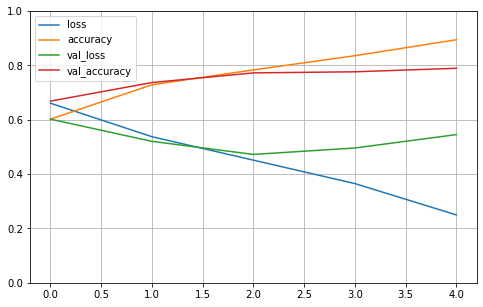

In [24]:
pd.DataFrame(history_model_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [25]:
probability_model_1 = tf.keras.Sequential([model_1, tf.keras.layers.Softmax()])

In [26]:
predictions_model_1 = probability_model_1.predict(X_validation)

In [27]:
predictions_model_1_list = []
for i in range(0, len(predictions_model_1)):
    predictions_model_1_list.append(np.argmax(predictions_model_1[i]))

<AxesSubplot:>

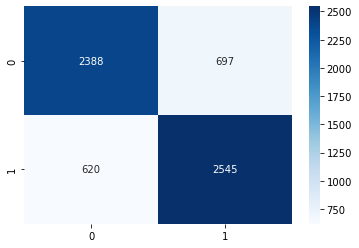

In [28]:
# confusion matrix
cm_model_1 = sklearn.metrics.confusion_matrix(np.argmax(y_validation, axis = 1), predictions_model_1_list)

sns.heatmap(cm_model_1, annot=True, fmt='d', cmap="Blues")

In [29]:
# goodness of fit metrics
print(classification_report(np.argmax(y_validation, axis = 1), predictions_model_1_list))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      3085
           1       0.79      0.80      0.79      3165

    accuracy                           0.79      6250
   macro avg       0.79      0.79      0.79      6250
weighted avg       0.79      0.79      0.79      6250



In [42]:
# ROC
fpr, tpr, thresholds = roc_curve(np.argmax(y_validation, axis = 1), predictions_model_1_list)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Model 1')

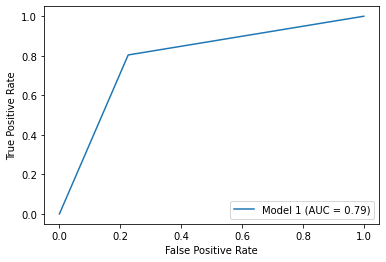

In [43]:
display.plot()
plt.show()

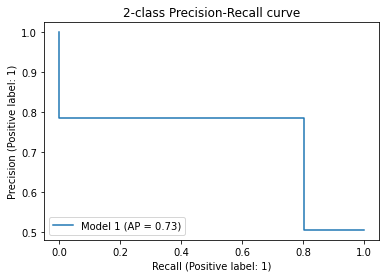

In [44]:
# Precision-Recall
display = PrecisionRecallDisplay.from_predictions(np.argmax(y_validation, axis = 1), predictions_model_1_list, name="Model 1")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [30]:
# test predictions
test_predictions_model_1 = probability_model_1.predict(X_test)

In [31]:
test_predictions_model_1_list = []
for i in range(0, len(test_predictions_model_1)):
    test_predictions_model_1_list.append(test_predictions_model_1[i][0])

In [33]:
os.chdir('/mnt/c/Users/jwnha/Documents/_School/MSDS/2022 Winter/Machine Learning/Week 8/cnn-identify-dogs-v-cats/submissions/')

In [34]:
Id = []
for i in range(1, len(test_predictions_model_1_list) + 1):
    Id.append(i)

m1_sub = pd.DataFrame(list(zip(Id, test_predictions_model_1_list)), columns = ['id', 'label'])
m1_sub.to_csv('model 1 submission.csv', index = False)

### Model 2

For model 2, I use model 1 as the base but add in an additional convolutional layer and max pooling layer before flattening.

I still use an early-stopping mechanism of validation loss increasing two epochs in a row.

After training the model, I use the validation set to get an estimate of the F-Stat, accuracy, and recall for the test set. 

Looking at the confusion matrix, we see that we correctly guess a greater amount of cats than dog pictures as there is a substantial drop in incorrect cat guesses from model 1 but incorrect dog guesses stayed constant. What is interesting is that the dog class has better precision by .08 but the cat class has better accuracy by .09. These differences offset and we have F-Stat scores that are close, .87 for the cat class and .86 for the dog class. By these metrics model 2 is an improvement over model 1. Overall, we see a ROC AUC of .87.

In [35]:
model_2 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

In [36]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [37]:
model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [38]:
history_model_2 = model_2.fit(X_train, y_train, epochs=30,
                              validation_data=(X_validation, y_validation),
                              callbacks=[callback])

Epoch 1/30
586/586 [==============================] - 180s 307ms/step - loss: 0.6829 - accuracy: 0.5501 - val_loss: 0.5770 - val_accuracy: 0.7112
Epoch 2/30
586/586 [==============================] - 185s 316ms/step - loss: 0.5358 - accuracy: 0.7295 - val_loss: 0.4625 - val_accuracy: 0.7854
Epoch 3/30
586/586 [==============================] - 190s 325ms/step - loss: 0.4002 - accuracy: 0.8191 - val_loss: 0.3841 - val_accuracy: 0.8277
Epoch 4/30
586/586 [==============================] - 158s 269ms/step - loss: 0.3310 - accuracy: 0.8559 - val_loss: 0.3620 - val_accuracy: 0.8370
Epoch 5/30
586/586 [==============================] - 174s 297ms/step - loss: 0.2670 - accuracy: 0.8843 - val_loss: 0.3138 - val_accuracy: 0.8661
Epoch 6/30
586/586 [==============================] - 179s 306ms/step - loss: 0.2088 - accuracy: 0.9108 - val_loss: 0.3165 - val_accuracy: 0.8680
Epoch 7/30
586/586 [==============================] - 150s 256ms/step - loss: 0.1497 - accuracy: 0.9388 - val_loss: 0.3369 -

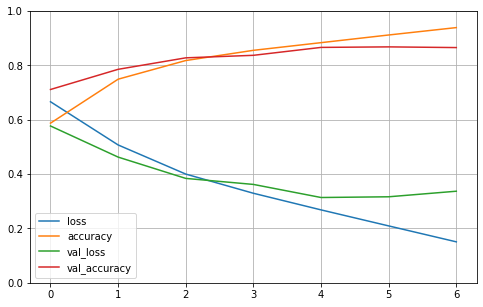

In [45]:
pd.DataFrame(history_model_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [46]:
probability_model_2 = tf.keras.Sequential([model_2, tf.keras.layers.Softmax()])

In [47]:
predictions_model_2 = probability_model_2.predict(X_validation)

In [48]:
predictions_model_2_list = []
for i in range(0, len(predictions_model_2)):
    predictions_model_2_list.append(np.argmax(predictions_model_2[i]))

<AxesSubplot:>

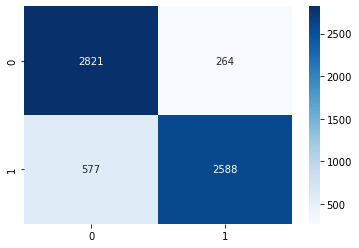

In [49]:
# confusion matrix
cm_model_2 = sklearn.metrics.confusion_matrix(np.argmax(y_validation, axis = 1), predictions_model_2_list)

sns.heatmap(cm_model_2, annot=True, fmt='d', cmap="Blues")

In [50]:
# goodness of fit metrics
print(classification_report(np.argmax(y_validation, axis = 1), predictions_model_2_list))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3085
           1       0.91      0.82      0.86      3165

    accuracy                           0.87      6250
   macro avg       0.87      0.87      0.87      6250
weighted avg       0.87      0.87      0.87      6250



In [51]:
# ROC
fpr, tpr, thresholds = roc_curve(np.argmax(y_validation, axis = 1), predictions_model_2_list)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Model 2')

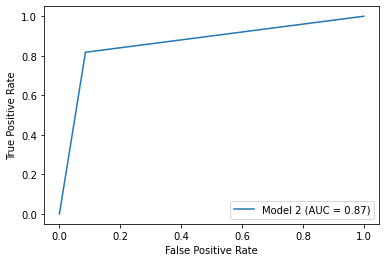

In [52]:
display.plot()
plt.show()

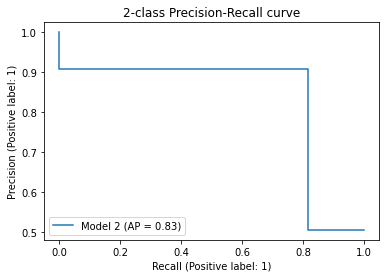

In [53]:
# Precision-Recall
display = PrecisionRecallDisplay.from_predictions(np.argmax(y_validation, axis = 1), predictions_model_2_list, name="Model 2")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [54]:
# test predictions
test_predictions_model_2 = probability_model_2.predict(X_test)

In [55]:
test_predictions_model_2_list = []
for i in range(0, len(test_predictions_model_2)):
    test_predictions_model_2_list.append(test_predictions_model_2[i][0])

In [56]:
Id = []
for i in range(1, len(test_predictions_model_2_list) + 1):
    Id.append(i)

m2_sub = pd.DataFrame(list(zip(Id, test_predictions_model_2_list)), columns = ['id', 'label'])
m2_sub.to_csv('model 2 submission.csv', index = False)

### Model 3

In model 3, I use model 2 as the base but add in drop-out layers after each pooling layer. This method helps decrease the overfitting since we lose information through the drop-out. Thus I extend the number of epochs with validation loss to four (from 2) since the expectation is that it will take longer to train the RNN.

After training the model, I use the validation set to get an estimate of the F-Stat, accuracy, and recall for the test set. 

Looking at the confusion matrix, we see a similar pattern as in model 2. The model correctly guesses a greater amount of cats than dog pictures. What is interesting is that the dog class has better precision by .06 but the cat class has better accuracy by .09. These differences offset and we have F-Stat scores that are close, .88 for the cat class and .87 for the dog class. All of these scores are better than model 2 by a margin of roughly .01. By these metrics model 3 is a slight improvement over model 2. Overall, we see a ROC AUC of .87 which is the same as model 2.

In [57]:
model_3 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), input_shape=X.shape[1:], activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='sigmoid')
])

In [58]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [59]:
model_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [60]:
history_model_3 = model_3.fit(X_train, y_train, epochs=30,
                              validation_data=(X_validation, y_validation),
                              callbacks=[callback])

Epoch 1/30
586/586 [==============================] - 212s 360ms/step - loss: 0.7012 - accuracy: 0.5081 - val_loss: 0.6949 - val_accuracy: 0.4936
Epoch 2/30
586/586 [==============================] - 207s 354ms/step - loss: 0.6891 - accuracy: 0.5389 - val_loss: 0.6443 - val_accuracy: 0.6354
Epoch 3/30
586/586 [==============================] - 209s 356ms/step - loss: 0.6420 - accuracy: 0.6332 - val_loss: 0.6156 - val_accuracy: 0.6595
Epoch 4/30
586/586 [==============================] - 212s 362ms/step - loss: 0.5694 - accuracy: 0.7041 - val_loss: 0.5387 - val_accuracy: 0.7195
Epoch 5/30
586/586 [==============================] - 211s 360ms/step - loss: 0.5279 - accuracy: 0.7372 - val_loss: 0.5191 - val_accuracy: 0.7357
Epoch 6/30
586/586 [==============================] - 209s 357ms/step - loss: 0.5063 - accuracy: 0.7546 - val_loss: 0.5102 - val_accuracy: 0.7395
Epoch 7/30
586/586 [==============================] - 210s 358ms/step - loss: 0.4747 - accuracy: 0.7763 - val_loss: 0.5358 -

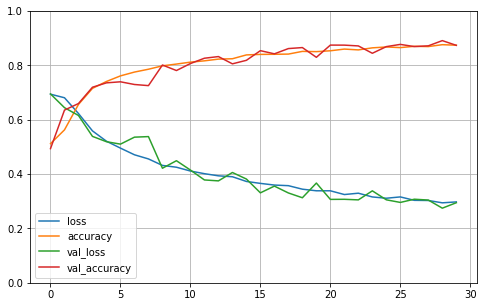

In [61]:
pd.DataFrame(history_model_3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [62]:
probability_model_3 = tf.keras.Sequential([model_3, tf.keras.layers.Softmax()])

In [63]:
predictions_model_3 = probability_model_3.predict(X_validation)

In [64]:
predictions_model_3_list = []
for i in range(0, len(predictions_model_3)):
    predictions_model_3_list.append(np.argmax(predictions_model_3[i]))

<AxesSubplot:>

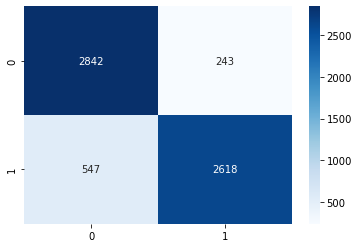

In [65]:
# confusion matrix
cm_model_3 = sklearn.metrics.confusion_matrix(np.argmax(y_validation, axis = 1), predictions_model_3_list)

sns.heatmap(cm_model_3, annot=True, fmt='d', cmap="Blues")

In [66]:
# goodness of fit metrics
print(classification_report(np.argmax(y_validation, axis = 1), predictions_model_3_list))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3085
           1       0.92      0.83      0.87      3165

    accuracy                           0.87      6250
   macro avg       0.88      0.87      0.87      6250
weighted avg       0.88      0.87      0.87      6250



In [67]:
# ROC
fpr, tpr, thresholds = roc_curve(np.argmax(y_validation, axis = 1), predictions_model_3_list)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Model 3')

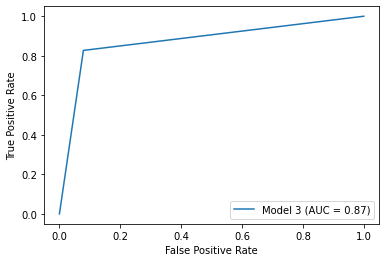

In [68]:
display.plot()
plt.show()

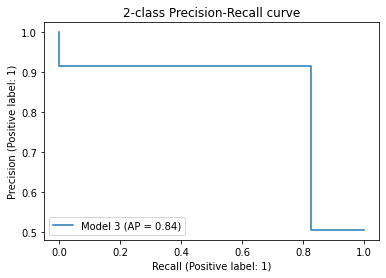

In [69]:
# Precision-Recall
display = PrecisionRecallDisplay.from_predictions(np.argmax(y_validation, axis = 1), predictions_model_3_list, name="Model 3")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [70]:
# test predictions
test_predictions_model_3 = probability_model_3.predict(X_test)

In [71]:
test_predictions_model_3_list = []
for i in range(0, len(test_predictions_model_3)):
    test_predictions_model_3_list.append(test_predictions_model_3[i][0])

In [72]:
Id = []
for i in range(1, len(test_predictions_model_3_list) + 1):
    Id.append(i)

m3_sub = pd.DataFrame(list(zip(Id, test_predictions_model_3_list)), columns = ['id', 'label'])
m3_sub.to_csv('model 3 submission.csv', index = False)

## Conclusion

While initially from the validation set it appeared Model 3 was slightly better than Model 2, in the end Model 3 was the winner, with Model 1 be slightly less good. This showed that using a drop-out layer after each pooling layer helped the model not over-fit on the training data. Something to check would be to change the early stopping to 4 straight epochs of an increase in validation loss for Model 1 and Model 2 and see if the log loss score improves. This would indicate that training was cut-off early for these models rather than the drop-out layers added in Model 3. 

### Results Table
| Metric | Model 1 | Model 2 | Model 3 |
|---     | ---     | ---     | ---     |
| Validation Accuracy | 0.79 | 0.87 | 0.87 | 
| Test Log Loss | 0.77 | 0.78 | 0.76 |